In [1]:
import os
import glob
import numpy as np
import random
import pandas as pd
import subprocess
import datetime 
import awswrangler as wr

In [2]:
from tensorflow import keras
import shap

In [3]:
shap.initjs()

In [211]:
pd.options.display.min_rows=135
pd.options.display.max_rows=135

In [5]:
def get_model_path(model_name):
    path = os.path.realpath('../build/models')
    return f"{path}/{model_name}/"


def load(model_name, model_version):
    model_path = get_model_path(model_name) + model_version
    return keras.models.load_model(model_path + "/model.h5", compile=False)


def get_features_path(data_folder, name=None):
    path = os.path.realpath('../build/features')
    if name:
        return f"{path}/{data_folder}/{name}/"
    else:
        return f"{path}/{data_folder}/"
    
    
def get_test_train_files(x_files, y_files, validation_rate, get_x_shape=False):
    """Get filenames of feature and annotation files in S3
    :param x_files: (list) List of np feature files
    :param y_files: (list) List of np labels
    :param validation_rate: (float) Rate of validation holdout out (>0.0,<1.0)
    :param get_x_shape: (bool)  Should the shape of x be returned.
                        Used to specify input layer size to model.

    :return:
    A list of feature and label filenames for training,
    and a list of validation feature and annotation filenames.
    If get_x_shape = True,
    the a tuple of (# x features,)
    """
    assert 0.0 < validation_rate < 1.0
    num_feature_files = len(x_files)
    random.seed(30)
    holdout_indexes = random.sample(
        list(np.arange(num_feature_files)), int(np.ceil(num_feature_files * validation_rate))
    )
    y_test_list = [y_files[i] for i in holdout_indexes]
    y_train_list = [f for f in y_files if f not in y_test_list]
    x_test_list = [x_files[i] for i in holdout_indexes]
    x_train_list = [f for f in x_files if f not in x_test_list]
    if get_x_shape:
        feature_file = x_files[0]
        x = np.load(feature_file, allow_pickle=True)
        x_shape = (x.shape[1],)
        return y_test_list, y_train_list, x_test_list, x_train_list, x_shape
    else:
        return y_test_list, y_train_list, x_test_list, x_train_list
    

def get_local_files(folder, subfolder, data_folder, file_type="npy"):
    file_path = get_features_path(data_folder, folder) + subfolder
    files = sorted(glob.glob(f"{file_path}/*.{file_type}"))
    return files


def get_all_local_files(
    data_folder,
    model_name,
    folders=["train", "holdout"],
    subfolders=["extracted_features", "annotation_label"],
):
    for folder in folders:
        for subfolder in subfolders:
            yield get_local_files(folder, subfolder, data_folder)
            
def download_files_from_s3(bucket, s3_folder_path, local_folder_path):
    s3_path = f"s3://{bucket}/{s3_folder_path}"
    print('Downloading from ', s3_path, 'to ', local_folder_path)
    subprocess.call(["aws", "s3", "cp", "--recursive", s3_path, local_folder_path])

    

In [6]:
download_files_from_s3('gd-cue-dev-private-model-training-data', 'nru/features/pltv_nru_train_data_20220324/train/annotation_id/', '/home/ec2-user/SageMaker/ltv-nc/build/features/pltv_nru_train_data_20220324/train/annotation_id')


KeyboardInterrupt: 

In [13]:
download_files_from_s3('gd-cue-dev-private-model-training-data', 'nru/features/pltv_nru_train_data_20220324/train/extracted_features/', '/home/ec2-user/SageMaker/ltv-nc/build/features/pltv_nru_train_data_20220324/train/extracted_features')


In [14]:
download_files_from_s3('gd-cue-dev-private-model-training-data', 'nru/features/pltv_nru_train_data_20220324/train/annotation_label/', '/home/ec2-user/SageMaker/ltv-nc/build/features/pltv_nru_train_data_20220324/train/annotation_label')


In [23]:
download_files_from_s3('gd-cue-dev-private-cerbo-sagemaker-model', 'nru/20220324/', '/home/ec2-user/SageMaker/ltv-nc/build/models/20220324')


In [6]:
x_train_files, y_train_files, x_holdout_files, y_holdout_files = get_all_local_files('pltv_nru_train_data_20220324', 'nru')

In [7]:
random_idxs = random.sample(range(len(x_train_files)), 100)
for i,n in enumerate(random_idxs):
    if i == 0:
        X = pd.DataFrame(np.load(x_train_files[n], allow_pickle=True))
        y = pd.DataFrame(np.load(y_train_files[n], allow_pickle=True))
    else:
        X_tmp = pd.DataFrame(np.load(x_train_files[n], allow_pickle=True))
        y_tmp = pd.DataFrame(np.load(y_train_files[n], allow_pickle=True))
        X = pd.concat([X, X_tmp])
        y = pd.concat([y, y_tmp])

In [8]:
model = load('nru', '20220324')

In [9]:
ex_X = X.sample(n=50)
explainer = shap.KernelExplainer(model = model.predict, data = ex_X, link = "identity")

[2022-05-06 01:41:18.310 ip-10-10-42-73:27858 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2022-05-06 01:41:18.372 ip-10-10-42-73:27858 INFO profiler_config_parser.py:111] Unable to find config at /opt/ml/input/config/profilerconfig.json. Profiler is disabled.


In [ ]:
download_files_from_s3('gd-cue-dev-private-model-inference-data', 'nru/features/pltv_nru_inference_data_20220323/inference/annotation_id/', '/home/ec2-user/SageMaker/ltv-nc/build/features/pltv_nru_inference_data_20220323/inference/annotation_id')


In [28]:
download_files_from_s3('gd-cue-dev-private-model-inference-data', 'nru/features/pltv_nru_inference_data_20220323/inference/extracted_features/', '/home/ec2-user/SageMaker/ltv-nc/build/features/pltv_nru_inference_data_20220323/inference/extracted_features')


In [10]:
X_test_20220323_id_files = get_local_files('inference', 'annotation_id', 'pltv_nru_inference_data_20220323', file_type="npy")
X_test_20220323_feature_files = get_local_files('inference', 'extracted_features', 'pltv_nru_inference_data_20220323', file_type="npy")

In [174]:
query = """
SELECT DISTINCT bill_id,
                ga_traffic_source_campaign_name AS campaign_name
FROM analytic.ads_bill_line_ext
WHERE ga_traffic_source_campaign_name IN ('en-us_diy-ols_sem_ci_nb_ecommerce-all-o_aware-consider_x_pros_us_exact_001'
    ,'en-us_diy-ols_sem_ci_nb_expansion-shopify_aware-consider_x_pros_us_exact_001'
    ,'en-us_diy-ols_sem_ci_nb_marketplace-all_aware-consider_x_pros_us_bmm_001'
    ,'en-us_diy-ols_sem_ci_nb_marketplace-all_aware-consider_x_pros_us_exact_001'
    ,'en-us_diy-ols_sem_ci_nb_online-shop-all-o_aware-consider_x_pros_us_exact_001'
    ,'en-us_diy-ols_sem_ci_nb_online-store-all-o_aware-consider_x_pros_us_exact_001'
    ,'en-us_diy-ols_sem_ci_nb_selling-all_aware-consider_x_pros_us_exact_001'
    ,'en-us_diy-ols_sem_ci_nb_website-all-o_aware-consider_x_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_site-builder-w_aware-consider_m_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_site-create-w_aware-consider_x_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_site-free-builder-w_aware-consider_x_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_site-free-creator-w_aware-consider_x_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_site-free-maker-w_aware-consider_x_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_site-free-w_aware-consider_x_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_site-howto-make-w_aware-consider_m_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_site-howto-make-w_aware-consider_x_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_site-maker-w_aware-consider_m_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_web-page-build_aware-consider_x_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_web-page-builder_aware-consider_m_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_web-page-create_aware-consider_m_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_web-page-create_aware-consider_x_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_web-page-creator_aware-consider_x_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_web-page-free-builder_aware-consider_x_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_web-page-free-create_aware-consider_x_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_web-page-free-howto-build_aware-consider_x_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_web-page-free-howto-create_aware-consider_x_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_web-page-free-howto-make_aware-consider_m_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_web-page-free-howto-make_aware-consider_x_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_web-page-free-maker_aware-consider_x_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_web-page-free_aware-consider_m_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_web-page-free_aware-consider_x_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_web-page-howto-build_aware-consider_m_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_web-page-howto-create_aware-consider_m_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_web-page-howto-create_aware-consider_x_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_web-page-howto-make_aware-consider_m_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_web-page-howto-make_aware-consider_x_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_web-page-howto-setup_aware-consider_m_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_web-page-howto-setup_aware-consider_x_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_web-page-howto-start_aware-consider_m_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_web-page-make_aware-consider_m_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_web-page-make_aware-consider_x_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_web-page-start_aware-consider_x_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_web-site-build-w_aware-consider_x_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_web-site-builder-w_aware-consider_m_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_web-site-builder-w_aware-consider_x_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_web-site-create-w_aware-consider_m_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_web-site-creator-w_aware-consider_m_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_web-site-free-builder-w_aware-consider_x_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_web-site-free-create-w_aware-consider_x_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_web-site-free-w_aware-consider_x_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_web-site-howto-build-w_aware-consider_x_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_web-site-howto-create-w_aware-consider_m_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_web-site-howto-create-w_aware-consider_x_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_web-site-howto-make-w_aware-consider_m_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_web-site-howto-make-w_aware-consider_x_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_web-site-make-w_aware-consider_x_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_web-site-w_aware-consider_m_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_web-site-w_aware-consider_x_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_webpage-build_aware-consider_x_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_webpage-create_aware-consider_m_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_webpage-create_aware-consider_x_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_webpage-free-create_aware-consider_x_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_webpage-free-creator_aware-consider_m_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_webpage-free_aware-consider_x_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_webpage-howto-create_aware-consider_m_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_webpage-howto-create_aware-consider_x_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_webpage-howto-make_aware-consider_m_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_webpage-howto-make_aware-consider_x_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_webpage-make_aware-consider_m_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_webpage_aware-consider_m_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_webpage_aware-consider_x_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_website-build-w_aware-consider_m_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_website-build-w_aware-consider_x_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_website-builder-w_aware-consider_m_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_website-builder-w_aware-consider_x_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_website-business_aware-consider_m_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_website-business_aware-consider_x_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_website-create-w_aware-consider_m_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_website-create-w_aware-consider_x_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_website-creator-w_aware-consider_m_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_website-creator-w_aware-consider_x_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_website-free-build-w_aware-consider_m_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_website-free-build-w_aware-consider_x_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_website-free-builder-w_aware-consider_m_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_website-free-builder-w_aware-consider_x_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_website-free-create-w_aware-consider_m_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_website-free-create-w_aware-consider_x_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_website-free-creator-w_aware-consider_m_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_website-free-creator-w_aware-consider_x_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_website-free-get-w_aware-consider_x_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_website-free-howto-build-w_aware-consider_m_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_website-free-howto-build-w_aware-consider_x_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_website-free-howto-create-w_aware-consider_m_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_website-free-howto-create-w_aware-consider_x_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_website-free-howto-get-w_aware-consider_m_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_website-free-howto-get-w_aware-consider_x_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_website-free-howto-make-w_aware-consider_m_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_website-free-howto-make-w_aware-consider_x_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_website-free-howto-setup-w_aware-consider_m_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_website-free-howto-setup-w_aware-consider_x_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_website-free-make-w_aware-consider_m_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_website-free-make-w_aware-consider_x_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_website-free-maker-w_aware-consider_m_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_website-free-maker-w_aware-consider_x_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_website-free-setup-w_aware-consider_x_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_website-free-start-w_aware-consider_m_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_website-free-start-w_aware-consider_x_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_website-free-w_aware-consider_m_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_website-free-w_aware-consider_x_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_website-get-w_aware-consider_m_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_website-get-w_aware-consider_x_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_website-howto-build-w_aware-consider_m_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_website-howto-build-w_aware-consider_x_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_website-howto-create-w_aware-consider_m_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_website-howto-create-w_aware-consider_x_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_website-howto-get-w_aware-consider_m_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_website-howto-get-w_aware-consider_x_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_website-howto-make-w_aware-consider_m_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_website-howto-make-w_aware-consider_x_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_website-howto-setup-w_aware-consider_m_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_website-howto-setup-w_aware-consider_x_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_website-howto-start-w_aware-consider_m_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_website-howto-start-w_aware-consider_x_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_website-make-w_aware-consider_m_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_website-make-w_aware-consider_x_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_website-maker-w_aware-consider_m_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_website-maker-w_aware-consider_x_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_website-setup-w_aware-consider_m_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_website-setup-w_aware-consider_x_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_website-start-w_aware-consider_m_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_website-start-w_aware-consider_x_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_website-w_aware-consider_m_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_website-w_aware-consider_x_pros_us_exact_001')
AND bill_modified_mst_date IN (DATE('2022-02-01'), DATE('2022-02-07'))
AND (new_registered_user_flag = TRUE OR new_acquisition_flag = TRUE)
"""

In [11]:
query_2 = """
SELECT DISTINCT bill_id,
                ga_traffic_source_campaign_name AS campaign_name
FROM analytic.ads_bill_line_ext
WHERE ga_traffic_source_campaign_name IN ('en-us_diy-ols_sem_ci_nb_ecommerce-all-o_aware-consider_x_pros_us_exact_001'
    ,'en-us_diy-ols_sem_ci_nb_expansion-shopify_aware-consider_x_pros_us_exact_001'
    ,'en-us_diy-ols_sem_ci_nb_marketplace-all_aware-consider_x_pros_us_bmm_001'
    ,'en-us_diy-ols_sem_ci_nb_marketplace-all_aware-consider_x_pros_us_exact_001'
    ,'en-us_diy-ols_sem_ci_nb_online-shop-all-o_aware-consider_x_pros_us_exact_001'
    ,'en-us_diy-ols_sem_ci_nb_online-store-all-o_aware-consider_x_pros_us_exact_001'
    ,'en-us_diy-ols_sem_ci_nb_selling-all_aware-consider_x_pros_us_exact_001'
    ,'en-us_diy-ols_sem_ci_nb_website-all-o_aware-consider_x_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_site-builder-w_aware-consider_m_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_site-create-w_aware-consider_x_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_site-free-builder-w_aware-consider_x_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_site-free-creator-w_aware-consider_x_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_site-free-maker-w_aware-consider_x_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_site-free-w_aware-consider_x_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_site-howto-make-w_aware-consider_m_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_site-howto-make-w_aware-consider_x_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_site-maker-w_aware-consider_m_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_web-page-build_aware-consider_x_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_web-page-builder_aware-consider_m_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_web-page-create_aware-consider_m_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_web-page-create_aware-consider_x_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_web-page-creator_aware-consider_x_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_web-page-free-builder_aware-consider_x_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_web-page-free-create_aware-consider_x_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_web-page-free-howto-build_aware-consider_x_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_web-page-free-howto-create_aware-consider_x_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_web-page-free-howto-make_aware-consider_m_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_web-page-free-howto-make_aware-consider_x_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_web-page-free-maker_aware-consider_x_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_web-page-free_aware-consider_m_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_web-page-free_aware-consider_x_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_web-page-howto-build_aware-consider_m_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_web-page-howto-create_aware-consider_m_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_web-page-howto-create_aware-consider_x_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_web-page-howto-make_aware-consider_m_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_web-page-howto-make_aware-consider_x_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_web-page-howto-setup_aware-consider_m_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_web-page-howto-setup_aware-consider_x_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_web-page-howto-start_aware-consider_m_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_web-page-make_aware-consider_m_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_web-page-make_aware-consider_x_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_web-page-start_aware-consider_x_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_web-site-build-w_aware-consider_x_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_web-site-builder-w_aware-consider_m_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_web-site-builder-w_aware-consider_x_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_web-site-create-w_aware-consider_m_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_web-site-creator-w_aware-consider_m_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_web-site-free-builder-w_aware-consider_x_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_web-site-free-create-w_aware-consider_x_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_web-site-free-w_aware-consider_x_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_web-site-howto-build-w_aware-consider_x_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_web-site-howto-create-w_aware-consider_m_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_web-site-howto-create-w_aware-consider_x_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_web-site-howto-make-w_aware-consider_m_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_web-site-howto-make-w_aware-consider_x_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_web-site-make-w_aware-consider_x_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_web-site-w_aware-consider_m_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_web-site-w_aware-consider_x_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_webpage-build_aware-consider_x_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_webpage-create_aware-consider_m_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_webpage-create_aware-consider_x_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_webpage-free-create_aware-consider_x_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_webpage-free-creator_aware-consider_m_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_webpage-free_aware-consider_x_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_webpage-howto-create_aware-consider_m_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_webpage-howto-create_aware-consider_x_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_webpage-howto-make_aware-consider_m_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_webpage-howto-make_aware-consider_x_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_webpage-make_aware-consider_m_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_webpage_aware-consider_m_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_webpage_aware-consider_x_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_website-build-w_aware-consider_m_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_website-build-w_aware-consider_x_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_website-builder-w_aware-consider_m_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_website-builder-w_aware-consider_x_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_website-business_aware-consider_m_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_website-business_aware-consider_x_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_website-create-w_aware-consider_m_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_website-create-w_aware-consider_x_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_website-creator-w_aware-consider_m_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_website-creator-w_aware-consider_x_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_website-free-build-w_aware-consider_m_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_website-free-build-w_aware-consider_x_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_website-free-builder-w_aware-consider_m_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_website-free-builder-w_aware-consider_x_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_website-free-create-w_aware-consider_m_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_website-free-create-w_aware-consider_x_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_website-free-creator-w_aware-consider_m_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_website-free-creator-w_aware-consider_x_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_website-free-get-w_aware-consider_x_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_website-free-howto-build-w_aware-consider_m_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_website-free-howto-build-w_aware-consider_x_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_website-free-howto-create-w_aware-consider_m_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_website-free-howto-create-w_aware-consider_x_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_website-free-howto-get-w_aware-consider_m_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_website-free-howto-get-w_aware-consider_x_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_website-free-howto-make-w_aware-consider_m_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_website-free-howto-make-w_aware-consider_x_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_website-free-howto-setup-w_aware-consider_m_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_website-free-howto-setup-w_aware-consider_x_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_website-free-make-w_aware-consider_m_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_website-free-make-w_aware-consider_x_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_website-free-maker-w_aware-consider_m_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_website-free-maker-w_aware-consider_x_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_website-free-setup-w_aware-consider_x_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_website-free-start-w_aware-consider_m_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_website-free-start-w_aware-consider_x_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_website-free-w_aware-consider_m_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_website-free-w_aware-consider_x_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_website-get-w_aware-consider_m_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_website-get-w_aware-consider_x_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_website-howto-build-w_aware-consider_m_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_website-howto-build-w_aware-consider_x_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_website-howto-create-w_aware-consider_m_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_website-howto-create-w_aware-consider_x_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_website-howto-get-w_aware-consider_m_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_website-howto-get-w_aware-consider_x_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_website-howto-make-w_aware-consider_m_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_website-howto-make-w_aware-consider_x_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_website-howto-setup-w_aware-consider_m_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_website-howto-setup-w_aware-consider_x_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_website-howto-start-w_aware-consider_m_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_website-howto-start-w_aware-consider_x_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_website-make-w_aware-consider_m_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_website-make-w_aware-consider_x_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_website-maker-w_aware-consider_m_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_website-maker-w_aware-consider_x_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_website-setup-w_aware-consider_m_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_website-setup-w_aware-consider_x_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_website-start-w_aware-consider_m_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_website-start-w_aware-consider_x_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_website-w_aware-consider_m_pros_us_exact_001'
    ,'en-us_diy-wsb_sem_ci_nb_website-w_aware-consider_x_pros_us_exact_001')
AND bill_modified_mst_date = DATE('2022-03-01')
AND (new_registered_user_flag = TRUE OR new_acquisition_flag = TRUE)
"""

In [12]:
order_ids_20220301 = wr.athena.read_sql_query(sql=query_2, ctas_approach=False, database='analytic')

In [175]:
order_ids = wr.athena.read_sql_query(sql=query, ctas_approach=False, database='analytic')

In [13]:
def build_id_and_feature_df(id_files, start_date, end_date, order_ids):
    count = 0
    for i, file in enumerate(id_files):
            tmp_id_df = pd.DataFrame(np.load(file, allow_pickle=True))
            tmp_id_df = tmp_id_df[(tmp_id_df[2] >= start_date) & (tmp_id_df[2] <= end_date)]
            tmp_id_df = tmp_id_df[tmp_id_df[1].isin(order_ids['bill_id'])]
            if len(tmp_id_df) > 0:
                tmp_feature_df = np.load(file.replace('annotation_id', 'extracted_features'))
                tmp_feature_df= pd.DataFrame(tmp_feature_df[tmp_id_df.index])
                if count == 0:
                    feature_df = tmp_feature_df.copy()
                    id_df = tmp_id_df.copy()
                    count += 1
                else:
                    feature_df = pd.concat([feature_df, tmp_feature_df.copy()])
                    id_df = pd.concat([id_df, tmp_id_df.copy()])
                del tmp_id_df, tmp_feature_df
            if i%500 == 0:
                print('Finished ', i, ' of ', len(id_files))
    return id_df, feature_df
            

In [14]:
start_date = datetime.date(year=2022,month=3,day=1)
end_date = datetime.date(year=2022,month=3,day=1)
X_test_20220301_ids, X_test_20220301_features = build_id_and_feature_df(X_test_20220323_id_files, start_date, end_date, order_ids_20220301)

Finished  0  of  12523
Finished  500  of  12523
Finished  1000  of  12523
Finished  1500  of  12523
Finished  2000  of  12523
Finished  2500  of  12523
Finished  3000  of  12523
Finished  3500  of  12523
Finished  4000  of  12523
Finished  4500  of  12523
Finished  5000  of  12523
Finished  5500  of  12523
Finished  6000  of  12523
Finished  6500  of  12523
Finished  7000  of  12523
Finished  7500  of  12523
Finished  8000  of  12523
Finished  8500  of  12523
Finished  9000  of  12523
Finished  9500  of  12523
Finished  10000  of  12523
Finished  10500  of  12523
Finished  11000  of  12523
Finished  11500  of  12523
Finished  12000  of  12523
Finished  12500  of  12523


In [16]:
start_date = datetime.date(year=2022,month=2,day=1)
end_date = datetime.date(year=2022,month=2,day=1)
X_test_20220201_ids, X_test_20220201_features = build_id_and_feature_df(X_test_20220323_id_files, start_date, end_date, order_ids)

Finished  0  of  12523
Finished  500  of  12523
Finished  1000  of  12523
Finished  1500  of  12523
Finished  2000  of  12523
Finished  2500  of  12523
Finished  3000  of  12523
Finished  3500  of  12523
Finished  4000  of  12523
Finished  4500  of  12523
Finished  5000  of  12523
Finished  5500  of  12523
Finished  6000  of  12523
Finished  6500  of  12523
Finished  7000  of  12523
Finished  7500  of  12523
Finished  8000  of  12523
Finished  8500  of  12523
Finished  9000  of  12523
Finished  9500  of  12523
Finished  10000  of  12523
Finished  10500  of  12523
Finished  11000  of  12523
Finished  11500  of  12523
Finished  12000  of  12523
Finished  12500  of  12523


In [176]:
start_date = datetime.date(year=2022,month=2,day=7)
end_date = datetime.date(year=2022,month=2,day=7)
X_test_20220207_ids, X_test_20220207_features = build_id_and_feature_df(X_test_20220323_id_files, start_date, end_date, order_ids)

Finished  0  of  12523
Finished  500  of  12523
Finished  1000  of  12523
Finished  1500  of  12523
Finished  2000  of  12523
Finished  2500  of  12523
Finished  3000  of  12523
Finished  3500  of  12523
Finished  4000  of  12523
Finished  4500  of  12523
Finished  5000  of  12523
Finished  5500  of  12523
Finished  6000  of  12523
Finished  6500  of  12523
Finished  7000  of  12523
Finished  7500  of  12523
Finished  8000  of  12523
Finished  8500  of  12523
Finished  9000  of  12523
Finished  9500  of  12523
Finished  10000  of  12523
Finished  10500  of  12523
Finished  11000  of  12523
Finished  11500  of  12523
Finished  12000  of  12523
Finished  12500  of  12523


In [15]:
label = 24

In [16]:
X_test_20220301_features = X_test_20220301_features.reset_index(drop=True)
X_test_20220301_ids = X_test_20220301_ids.reset_index()

In [17]:
X_test_20220301_sample = X_test_20220301_features.sample(300, replace=False).sort_index()
X_test_20220301_ids_sample = X_test_20220301_ids[X_test_20220301_ids.index.isin(X_test_20220301_sample.index)].sort_index()

In [19]:
X_test_20220201_features = X_test_20220201_features.reset_index(drop=True)
X_test_20220201_ids = X_test_20220201_ids.reset_index()

In [20]:
X_test_20220201_sample = X_test_20220201_features.sample(300, replace=False).sort_index()
X_test_20220201_ids_sample = X_test_20220201_ids[X_test_20220201_ids.index.isin(X_test_20220201_sample.index)].sort_index()

In [177]:
X_test_20220207_features = X_test_20220207_features.reset_index(drop=True)
X_test_20220207_ids = X_test_20220207_ids.reset_index()

In [180]:
X_test_20220207_sample = X_test_20220207_features.sample(300, random_state=1, replace=False).sort_index()
X_test_20220207_ids_sample = X_test_20220207_ids[X_test_20220207_ids.index.isin(X_test_20220207_sample.index)].sort_index()

In [18]:
shap_values_20220301 = explainer.shap_values(X_test_20220301_sample)

  0%|          | 0/300 [00:00<?, ?it/s]

In [23]:
shap_values_20220201 = explainer.shap_values(X_test_20220201_sample)

  0%|          | 0/300 [00:00<?, ?it/s]

In [24]:
shap_values_20220207 = explainer.shap_values(X_test_20220207_sample)

  0%|          | 0/300 [00:00<?, ?it/s]

In [19]:
np.save('/home/ec2-user/SageMaker/shap_values_20220301.npy', shap_values_20220301)

In [27]:
#np.save('/home/ec2-user/SageMaker/shap_values_20220201.npy', shap_values_20220201)
#np.save('/home/ec2-user/SageMaker/shap_values_20220207.npy', shap_values_20220207)

In [23]:
shap_values_20220201 = np.load('/home/ec2-user/SageMaker/shap_values_20220201.npy')
shap_values_20220207 = np.load('/home/ec2-user/SageMaker/shap_values_20220207.npy')

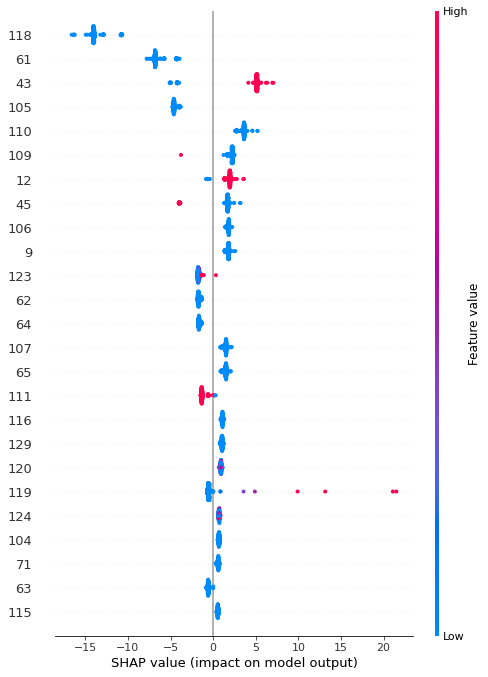

In [56]:
shap.summary_plot(shap_values = shap_values_20220201[label],
                  features = X_test_20220201_sample,
                  max_display=25
                  )

In [58]:
feature_lookup[46]

'ga_device_category_name_emb_vocab - TABLET'

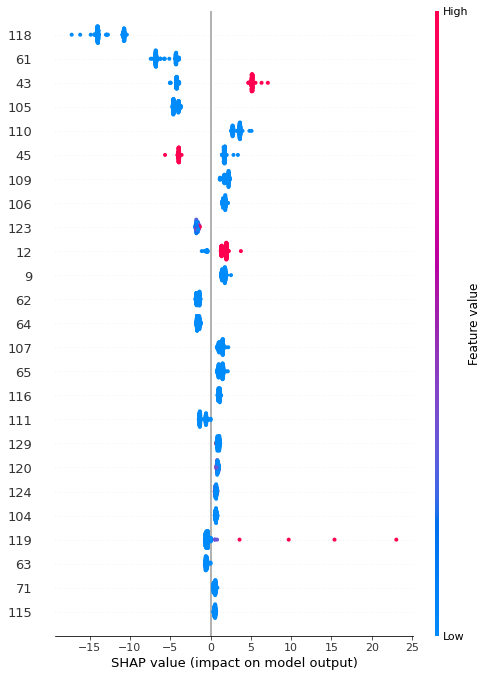

In [57]:
shap.summary_plot(shap_values = shap_values_20220207[label],
                  features = X_test_20220207_sample,
                  max_display=25
                  )

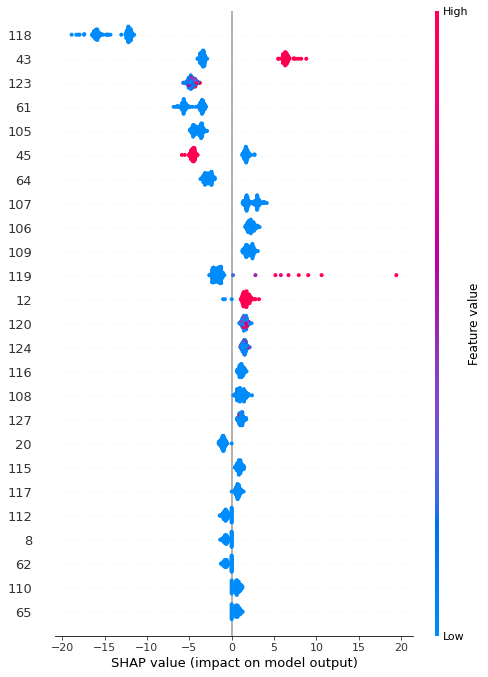

In [20]:
shap.summary_plot(shap_values = shap_values_20220301[label],
                  features = X_test_20220301_sample,
                  max_display=25
                  )

In [221]:
feature_lookup[12]

'purchase_path_name_emb_vocab - UNKNOWN'

In [106]:
shap.force_plot(explainer.expected_value[label],
                shap_values_20220201[label],
                X_test_20220201_sample, link="identity")

In [107]:
shap.force_plot(explainer.expected_value[label],
                shap_values_20220207[label],
                X_test_20220207_sample, link="identity")

In [21]:
shap.force_plot(explainer.expected_value[label],
                shap_values_20220301[label],
                X_test_20220301_sample, link="identity")

In [47]:
shap.force_plot(explainer.expected_value[label], shap_values_20220201[0][173,:], X_test_20220201_sample.iloc[173,:], link="identity")

In [24]:
shap.force_plot(explainer.expected_value[label], shap_values_20220207[0][53,:], X_test_20220207_sample.iloc[53,:], link="identity")

NameError: name 'X_test_20220207_sample' is not defined

In [49]:
shap.force_plot(explainer.expected_value[label], shap_values_20220207[0][94,:], X_test_20220207_sample.iloc[94,:], link="identity")

In [98]:
shap.force_plot(explainer.expected_value[label], shap_values_20220301[label][273], X_test_20220301_sample.iloc[273,:], link="identity")

In [97]:
shap.force_plot(explainer.expected_value[label], shap_values_20220301[label][272], X_test_20220301_sample.iloc[272,:], link="identity")

In [161]:
for i, val in enumerate(shap_values_20220301[label][272]):
    print(f"Feature {feature_lookup[i]} has SHAP value {val}")

Feature month_emb_vocab - 10 has SHAP value 0.0
Feature month_emb_vocab - 8 has SHAP value 0.0
Feature month_emb_vocab - 7 has SHAP value 0.0
Feature month_emb_vocab - 9 has SHAP value 0.0
Feature month_emb_vocab - 11 has SHAP value 0.14656776244512315
Feature month_emb_vocab - 4 has SHAP value 0.23090395220616866
Feature month_emb_vocab - 5 has SHAP value 0.4775201265730752
Feature month_emb_vocab - 6 has SHAP value 0.0
Feature month_emb_vocab - 3 has SHAP value -0.6218800841345136
Feature month_emb_vocab - 2 has SHAP value 0.0
Feature month_emb_vocab - 1 has SHAP value 0.0
Feature month_emb_vocab - 12 has SHAP value 0.12631856604955338
Feature purchase_path_name_emb_vocab - UNKNOWN has SHAP value 1.4028217077983827
Feature purchase_path_name_emb_vocab - SINGLE LANDING PAGE has SHAP value 0.0
Feature purchase_path_name_emb_vocab - HOMEPAGE QUICKBUY has SHAP value 0.2981033146805271
Feature purchase_path_name_emb_vocab - DYNAMIC LANDING PAGE has SHAP value 0.5971641526253302
Feature pu

In [42]:
feature_parquet = pd.read_parquet(os.path.realpath('../build/features/pltv_nru_train_data_20220324/train/extracted_features.parquet/part-00004-7edf72a8-4646-49cd-adc6-9ef6c750ef85-c964.snappy.parquet'))
month_emb_vocab = wr.s3.read_parquet(path='s3://gd-cue-dev-private-model-training-data/nru/features/pltv_nru_train_data_20220324/train/feature_extractor_pipeline/stages/000_CountVectorizer_67f44fc1709a/data/part-00000-1282ef94-625f-476d-8feb-40abc3ff65dc-c000.snappy.parquet')
purchase_path_name_emb_vocab = wr.s3.read_parquet(path='s3://gd-cue-dev-private-model-training-data/nru/features/pltv_nru_train_data_20220324/train/feature_extractor_pipeline/stages/001_CountVectorizer_b2bb55fe9016/data/part-00000-b853682f-cca2-4fe5-aaaa-d34a966849a0-c000.snappy.parquet')
reseller_type_name_emb_vocab = wr.s3.read_parquet(path='s3://gd-cue-dev-private-model-training-data/nru/features/pltv_nru_train_data_20220324/train/feature_extractor_pipeline/stages/002_CountVectorizer_42953b621a0d/data/part-00000-e8ad47b7-5f21-43eb-8209-122682da1cff-c000.snappy.parquet')
ga_device_category_name_emb_vocab = wr.s3.read_parquet(path='s3://gd-cue-dev-private-model-training-data/nru/features/pltv_nru_train_data_20220324/train/feature_extractor_pipeline/stages/003_CountVectorizer_dd84b76cde97/data/part-00000-574ebfe9-9a53-48c7-91a2-f2953a010076-c000.snappy.parquet')
primary_payment_subtype_name_emb_vocab = wr.s3.read_parquet(path='s3://gd-cue-dev-private-model-training-data/nru/features/pltv_nru_train_data_20220324/train/feature_extractor_pipeline/stages/004_CountVectorizer_b84d08baa026/data/part-00000-1480f6db-88d7-4db6-bf08-c260dd00ff67-c000.snappy.parquet')
ga_channel_grouping_name_emb_vocab = wr.s3.read_parquet(path='s3://gd-cue-dev-private-model-training-data/nru/features/pltv_nru_train_data_20220324/train/feature_extractor_pipeline/stages/005_CountVectorizer_f3ad04d2717f/data/part-00000-cfa51ca1-4a99-44e9-9598-7bf62fe9e027-c000.snappy.parquet')
order_metro_code_emb_vocab = wr.s3.read_parquet(path='s3://gd-cue-dev-private-model-training-data/nru/features/pltv_nru_train_data_20220324/train/feature_extractor_pipeline/stages/006_CountVectorizer_450373ab1f3d/data/part-00000-0ad8b112-5021-4863-a2c0-374b6d8af231-c000.snappy.parquet')
bill_report_region_2_name_feature_emb_vocab = wr.s3.read_parquet(path='s3://gd-cue-dev-private-model-training-data/nru/features/pltv_nru_train_data_20220324/train/feature_extractor_pipeline/stages/007_CountVectorizer_f74a8115565a/data/part-00000-9a7f7424-ae8b-4100-b5d9-192bf07042db-c000.snappy.parquet')
ga_client_emb_vocab = wr.s3.read_parquet(path='s3://gd-cue-dev-private-model-training-data/nru/features/pltv_nru_train_data_20220324/train/feature_extractor_pipeline/stages/008_CountVectorizer_e7e0124dde8c/data/part-00000-644f85a8-0086-4524-a0e0-835f358f32eb-c000.snappy.parquet')

In [43]:
feature_lookup = []
for feature in month_emb_vocab.iloc[0][0]:
    feature_lookup.append(f'month_emb_vocab - {feature}')
for feature in purchase_path_name_emb_vocab.iloc[0][0]:
    feature_lookup.append(f'purchase_path_name_emb_vocab - {feature}')
for feature in reseller_type_name_emb_vocab.iloc[0][0]:
    feature_lookup.append(f'reseller_type_name_emb_vocab - {feature}')
for feature in ga_device_category_name_emb_vocab.iloc[0][0]:
    feature_lookup.append(f'ga_device_category_name_emb_vocab - {feature}')
for feature in primary_payment_subtype_name_emb_vocab.iloc[0][0]:
    feature_lookup.append(f'primary_payment_subtype_name_emb_vocab - {feature}')
for feature in ga_channel_grouping_name_emb_vocab.iloc[0][0]:
    feature_lookup.append(f'ga_channel_grouping_name_emb_vocab - {feature}')
for feature in order_metro_code_emb_vocab.iloc[0][0]:
    feature_lookup.append(f'order_metro_code_emb_vocab - {feature}')
for feature in bill_report_region_2_name_feature_emb_vocab.iloc[0][0]:
    feature_lookup.append(f'bill_report_region_2_name_feature_emb_vocab - {feature}')
for feature in ga_client_emb_vocab.iloc[0][0]:
    feature_lookup.append(f'ga_client_emb_vocab - {feature}')
for feature in feature_parquet.columns[9:41]:
    feature_lookup.append(feature)


In [194]:
reverse_feature_lookup = {}
for i, f in enumerate(feature_lookup):
    reverse_feature_lookup[f] = i

In [195]:
reverse_feature_lookup['vnext_freemium_qty_emb']

111

In [44]:
feature_lookup

['month_emb_vocab - 10',
 'month_emb_vocab - 8',
 'month_emb_vocab - 7',
 'month_emb_vocab - 9',
 'month_emb_vocab - 11',
 'month_emb_vocab - 4',
 'month_emb_vocab - 5',
 'month_emb_vocab - 6',
 'month_emb_vocab - 3',
 'month_emb_vocab - 2',
 'month_emb_vocab - 1',
 'month_emb_vocab - 12',
 'purchase_path_name_emb_vocab - UNKNOWN',
 'purchase_path_name_emb_vocab - SINGLE LANDING PAGE',
 'purchase_path_name_emb_vocab - HOMEPAGE QUICKBUY',
 'purchase_path_name_emb_vocab - DYNAMIC LANDING PAGE',
 'purchase_path_name_emb_vocab - P & C - VNEXT',
 'purchase_path_name_emb_vocab - AFTER CHECKOUT SPECIAL',
 'purchase_path_name_emb_vocab - DOMAIN PURCHASE PATH',
 'purchase_path_name_emb_vocab - MOBILE APPS - IOS',
 'purchase_path_name_emb_vocab - DOMAINS - DCC 6',
 'purchase_path_name_emb_vocab - DOMAIN CONTROL CENTER',
 'purchase_path_name_emb_vocab - MULTI LANDING PAGE',
 'purchase_path_name_emb_vocab - MOBILE APPS - ANDROID',
 'purchase_path_name_emb_vocab - GODADDY PRO - PRO DASHBOARD',
 'pu